In [7]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
import weightwatcher as ww

watcher = ww.WeightWatcher()

INFO:weightwatcher:

python      version 3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
numpy       version 1.19.5


In [14]:
from transformers import AlbertModel

version = 'base'
model_name = f"albert-{version}-v2"
albert = AlbertModel.from_pretrained(model_name)

watcher = ww.WeightWatcher(model=albert)
details = watcher.analyze(randomize=True, mp_fit=True, detX=True)


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.LayerNorm.weight', 'predictions.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:weightwatcher:

python      version 3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
numpy       version 1.19.5
torch version 1.12.1




python      version 3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
numpy       version 1.19.5
torch version 1.12.1


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': False, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'detX': True, 'mp_fit': True, 'min_evals': 50, 'max_evals': 10000, 'max_N': 10, 'tolerance': 1e-06, 'layer_ids_start': 0, 'add_biases': False, 'glorot_fit': False, 'layers': [], 'xmin_max': None}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:torch version 1.12.1
INFO:weightwatcher:framework from model = 2


KeyboardInterrupt: 

In [ ]:
W = watcher.get_Weights(layer=17)[0]

###  if W has converged, we should  be able to fit it elementwise to a Lapacian distribution

In [ ]:
from scipy.stats import kstest, laplace
import numpy as np

def fit_laplacian(W, plot=True, sample_size=10000):
    """Fits the elements of a matrix W to a Laplacian density
    
    Returns the parameters of the fit and quality
    
    """
    W_elements = W.flatten()
    loc, scale = laplace.fit(W_elements)
    
    # Create theoretical Laplacian distribution
    lap_dist = laplace(loc, scale)

    D, p = kstest(W_elements, lap_dist.cdf)

    if plot:
        # sample from W
        data = np.random.choice(W_elements, size=sample_size, replace=True)
        plt.hist(data, bins=1000, density=True, alpha=0.6, color='b', label='Sample Data')


        # Plot the fitted Laplacian distribution
        x = np.linspace(lap_dist.ppf(0.01), lap_dist.ppf(0.99), 100)
        plt.plot(x, lap_dist.pdf(x), 'r-', lw=2, alpha=0.6, label='Fitted Laplacian')
    
        plt.legend()
        plt.show()
        
        
    print(f"loc={loc:0.2f} scale={scale:0.2f} D={D:0.2f} p={p:0.2f}")
    
    return loc, scale, D, p
    

In [ ]:
loc, scale, D, p = fit_laplacian(W)

### The energy function is RELU(Wx+b)

How can this be tested withoout using real data

Use Gaussian data ?

In [ ]:
from scipy.stats import maxwell

def fit_maxwell(W, plot=True, sample_size=10000):
    """Fits the elements of a matrix W to a Maxwell Boltzman
    
    THis is WRONG
    Returns the parameters of the fit and quality
    
    """
    # flatten array
    W_elements =(W.flatten())
    
    # apply relu
    #indices = np.random.choice(np.arange(W_elements.size), replace=False,
    #                       size=int(W_elements.size * 0.5))
    #W_elements[indices] = 0
    
    # fit to MW dist

    params = maxwell.fit(W_elements)
    
    # Create theoretical Maxwell Boltzmann distribution
    loc, scale = params[0], params[1]
    mw_dist = maxwell(loc, scale)

    D, p = kstest(W_elements, mw_dist.cdf)

    if plot:
        # sample from W
        data = np.random.choice(W_elements, size=sample_size, replace=True)
        plt.hist(data, bins=1000, density=True, alpha=0.6, color='b', label='Sample Data')


        # Plot the fitted Laplacian distribution
        x = np.linspace(mw_dist.ppf(0.01), mw_dist.ppf(0.99), 100)
        plt.plot(x, mw_dist.pdf(x), 'r-', lw=2, alpha=0.6, label='Fitted Boltzmann')
    
        plt.legend()
        plt.show()
        
        
    print(f"loc={loc:0.2f} scale={scale:0.2f} D={D:0.2f} p={p:0.2f}")
    
    return loc, scale, D, p
    

In [ ]:
loc, scale, D, p = fit_maxwell(W)

### Look at different Laplacians

In [ ]:
layer_ids = details.layer_id.to_numpy()

In [ ]:
laplacian_scales = []
laplacian_Ds = []
max_W = []

for layer_id in layer_ids:
    W = watcher.get_Weights(layer=layer_id)[0];
    loc, scale, D, p = fit_laplacian(W, plot=False);
    laplacian_scales.append(scale)
    laplacian_Ds.append(D)
    max_W.append(np.max(np.abs(W)))

In [ ]:
plt.scatter(details.alpha.to_numpy(), max_W)
plt.xlim(1,5)
plt.xlabel(r"Power Law fit: alpha $\alpha$")
plt.ylabel("Laplacian fit: scale")
plt.title("ALBERT: Power Law fit vs Laplacian fit")

In [ ]:
plt.scatter(details.alpha.to_numpy(), max_W)
plt.xlabel(r"Power Law fit: alpha $\alpha$")
plt.ylabel("max W")
plt.title("ALBERT: Power Law fit vs Max W")


In [ ]:
for alpha, scale in zip(details.alpha.to_numpy(), laplacian_scales):
    lap_dist = laplace(0.0, scale)
    
    #if alpha < 6 and alpha > 1.5:

    if alpha> 4 or alpha < 2 or (alpha > 3 and alpha < 3.07):
        # Plot the fitted Laplacian distribution
        x = np.linspace(lap_dist.ppf(0.01), lap_dist.ppf(0.99), 100)
        plt.plot(x, lap_dist.pdf(x),  lw=2, alpha=0.6, label=r"$\alpha=$"+f"{alpha:0.2f}")

plt.title("Laplacian fits for  few ALBERT layers"            )
plt.legend()
plt.show()

In [ ]:
for alpha, scale in zip(details.alpha.to_numpy(), laplacian_scales):
    lap_dist = laplace(0.0, scale)
    

    # Plot the fitted Laplacian distribution
    if alpha < 2:
        x = np.linspace(lap_dist.ppf(0.01), lap_dist.ppf(0.99), 100)
        plt.plot(x, lap_dist.pdf(x),  lw=2, alpha=0.6, label=r"$\alpha=$"+f"{alpha:0.2f}")

plt.title("Laplacian fits for  few ALBERT layers"            )
plt.legend()
plt.show()

In [ ]:
plt.scatter(laplacian_scales, max_W)
plt.xlabel(r"laplacian_scales")
plt.ylabel("max W")
plt.title("ALBERT: Max W vs Laplacian fit")
#plt.ylim(0,2)

In [ ]:
plt.scatter(laplacian_scales, max_W)
plt.xlabel(r"laplacian_scales")
plt.ylabel("max W")
plt.title("ALBERT: Max W vs Laplacian fit")
plt.ylim(0,2)

In [ ]:
details

In [ ]:
watcher.analyze(layers=[26], plot=True)

In [ ]:
esd = watcher.get_ESD(layer=17)

In [ ]:
plt.hist(esd, log=True, bins=100);

In [ ]:
plt.hist(np.log10(esd), log=True, bins=100);

In [ ]:

plt.hist(np.log10(esd[esd>10]), log=True, bins=100);

In [ ]:
details_17_xxlarge = watcher.analyze(layers=[17], fix_fingers='xmin_peak', xmin_max = 15, plot=True)

### VGG


In [ ]:
import weightwatcher as ww
import logging

In [ ]:
import torchvision.models as models
model = models.vgg11(weights='VGG11_Weights.IMAGENET1K_V1')
watcher = ww.WeightWatcher(model=model, log_level=logging.WARNING)

In [ ]:
details = watcher.analyze(layers=[5], plot=True)
details.alpha.to_numpy()[0]

In [ ]:
details = watcher.analyze(layers=[5], plot=True, fix_fingers='xmin_peak', xmin_max=1.0)
details.alpha.to_numpy()[0]

In [ ]:
details = watcher.analyze(layers=[5], fix_fingers='clip_xmax', plot=True)
details

In [ ]:
details = watcher.describe()
len(details)


## ChatGPT 

INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': None, 'fit': 'power_law', 'sparsify': True, 'detX': True, 'mp_fit': False, 'min_evals': 0, 'max_evals': None, 'max_N': 10, 'tolerance': 1e-06, 'layer_ids_start': 0, 'add_biases': False, 'glorot_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': None, 'f

(768, 768)
1.24909508228302


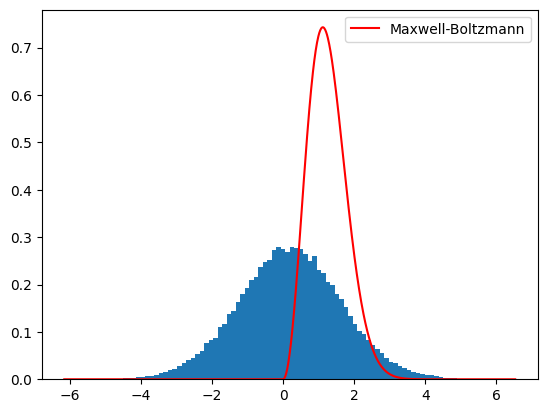

In [56]:
from scipy.stats import maxwell

W = watcher.get_Weights(layer=17)[0]

print(W.shape)
def energy_function(W, x):
    return np.dot(W, x)+0.2

# Generate a sample of 1000 random data points with Gaussian iid distribution
np.random.seed(0)
x_sample = np.random.normal(size=(768, 768))

# Evaluate the Energy function for each sample with ReLU
E_sample = energy_function(W, x_sample)

# Subsample the data by randomly selecting 100 data points
subsample_size = 100
subsample_index = np.random.choice(E_sample.shape[0], subsample_size, replace=False)
E_subsample = E_sample[subsample_index,:]

# Flatten the 2-dimensional array into a 1-dimensional array
E_subsample = E_subsample.ravel()

E_subsample = E_subsample

# Estimate the temperature T using the maxwell.fit function
loc, scale = maxwell.fit(E_subsample, floc=0)
T = 2*scale**2

print(T)
# Plot the histogram of E values
plt.hist(E_subsample, bins=100,  density=True);
# Plot the fitted Maxwell-Boltzmann distribution
E = np.linspace(E_subsample.min(), E_subsample.max(), 1000)
plt.plot(E, maxwell.pdf(E, scale = np.sqrt(T/2)), 'r', label='Maxwell-Boltzmann')
plt.legend()
plt.show()

In [48]:
np.max(W)

0.29975015